# Modelos LSTM

## 1. Introducción a LSTM

LSTM es un acrónimo de *Long-Short Term Memory* y representa a un **subtipo de RNN** (*Recurrent Neural Network*) capaz de **retener información relevante** sobre datos ya procesados que ayude al procesamiento de nuevas secuencias de datos completas. Su arquitectura se encuentra compuesta a su vez por tres redes neuronales:

* ***Forget Gate***: este primer modelo es el encargado de filtrar qué información previa es útil para su almacenamiento y qué datos ya no son útiles para futuras iteraciones. 

* ***Input Gate***: esta segunda red trata de determinar el valor que presentan los datos entrantes para resolver la tarea de clasificación.

* ***Output Gate***: finalmente esta red calcula las salidas del modelo LSTM que dependerán de la tarea de clasificación que se pretende abordar.

### 1.1. Condiciones de uso

Dependiendo del framework que se pretenda utilizar (Tensorflow, Keras, Pytorch) existen diferentes tratamientos de datos y requisitos de implementación que se deben cumplir al definir la arquitectura, entrenamiento y validación de modelos. En mi caso particular he optado por utilizar **Keras** debido a la experiencia previa que tengo con la librería y a su facilidad de uso. 

1. **Procesamiento y limpieza** de los documentos.

2. **Tokenización** de los documentos especificando un token para aquellos términos que no sean reconocidos dentro de un vocabulario de palabras.

3. **Codificación** numérica en forma de matrices secuenciales de valores. 

5. **Normalización** de las secuencias numéricas para establecer un mismo tamaño fijo, completando con ceros aquellas de menor longitud y separando en varias secuencias aquellas que dispongan de un mayor tamaño.

6. Definición de la arquitectura de un **modelo** e instanciación para su posterior entrenamiento y validación.

### 1.2. Casos de uso

* Detección y extracción de patrones en secuencias de datos.
* Modelado del lenguaje natural.
* Traducción de texto.
* Reconocimiento de textos manuscritos.
* Generación de imágenes mediante mecanismos de atención.
* Sistemas de preguntas y respuestas.
* Conversión de vídeo a texto.

## 2. Estructura del notebook

1. Introducción a LSTM
2. Estructura del notebook
3. Instalación y carga de librerías
4. Lectura y carga de datos
5. Experimentos y modelos
6. Conclusiones

## 3. Instalación y carga de librerías

Este apartado tiene como único propósito cargar las librerías y dependencias necesarias para la ejecución de este notebook, así como las funciones propiamente desarrolladas. Previo a ello deberán ser instaladas bien ejecutando el script *setup.sh* mediante el comando `bash setup.sh` con permisos de ejecución en distribuciones Linux, o bien ejecutando el compando `pip install -r requirements.txt`.

In [1]:
%%capture
import sys
sys.path.append("../scripts")

# Import data read and compute functions
from data import read_train_dataset, read_test_dataset

# Import text preprocess functions
from processing import *

# numpy: to work with numeric codifications and embeddings
import numpy as np

# keras: to define and build LSTM models
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import LSTM, Activation, Dense, Input, Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# sklearn: to plot a confusion matrix per trained model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# matplotlib: to plot charts
import matplotlib.pyplot as plt

2023-02-05 14:10:36.165320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 14:10:36.628511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 14:10:36.628590: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 14:10:37.794184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## 4. Lectura y carga de datos originales

En esta sección se pretende **cargar los datasets de entrenamiento y validación** procedentes de los correspondientes ficheros situados en la carpeta *data*. Al tener un **formato TSV** se deben leer como tablas aunque posteriormente se trabaje con ellos en formato *dataframe*. 

Tal y como se puede comprobar en los siguientes resultados las dimensiones de sendos conjuntos de datos se detallan a continuación:

* Conjunto de entrenamiento: **6.977 muestras**.
* Conjunto de validación: **4.368 muestras**.

In [2]:
# Read EXIST datasets
train_df = read_train_dataset()
test_df = read_test_dataset()

# Show the dimensions of the datasets
print("Train dataset dimensions:", train_df.shape)
print("Test dataset dimensions:", test_df.shape)

Train dataset dimensions: (6977, 7)
Test dataset dimensions: (4368, 7)


## 5. Experimentos y modelos

Esta sección pretende detallar los experimentos que se realizan a través de la combinación de diferentes técnicas de procesamiento de textos, codificación de documentos y arquitecturas de modelos LSTM. Como se trata de **experimentos no determinísticos**, es decir, los resultados difieren en varias ejecuciones aún con la misma configuración, la estrategia a seguir consiste en realizar **30 iteraciones de cada experimento** para luego calcular la **media de accuracy y AUC**, las métricas de evaluación escogidas para medir la calidad de un clasificador. 

Por lo tanto las siguientes secciones contienen los detalles del conjunto de experimentos realizados y las conclusiones comparativas alcanzadas, incluyendo el código, la configuración y los resultados únicamente del experimento con mejor rendimiento con respecto a las métricas de evaluación mencionadas.

Previo al comienzo de la experimentación se definen tres funciones comunes para el tratamiento y codificación de documentos, carga de embeddings pre-entrenados y validación de modelos.

In [3]:
def get_train_test_matrix(
    max_n_words: int, sequence_len: int, 
    lemm: bool = False, stemm: bool = False):
    """
    Process the train and test documents to then convert them
    into numeric sequence matrixes so the datasets can be
    used to train a LSTM model.

    Parameters
    ----------
    max_n_words : int
        Maximum number of words to keep within the LSTM memory
        based on computing the word frequency.
    sequence_len : int
        Maximum lenght of all sequences.
    lemm : bool (optional)
        True to apply lemmatization to the train and test documents.
    stemm : bool (optional)
        True to apply stemming to the train and test documents.

    Returns
    -------
    A dictionary with the following keys:
        - 'tokenizer': a Keras Tokenizer object based on the train documents
        that contains the vocabulary to then be used to create the embeddings.
        - 'train_matrix', 'test_matrix': the numeric sequence matrixes
        after converting the train and test documents.
        - 'train_labels', 'test_labels': two numeric lists which contains
        the encoded class labels for train and test datasets.
    """
    # Process train and test text documents
    processed_df = process_encode_datasets(
        train_df=train_df, 
        test_df=test_df,
        lemm=lemm, 
        stemm=stemm
    )

    # Processed train texts and encoded train labels 
    train_texts = list(processed_df["train_df"]["cleaned_text"].values)
    train_labels = processed_df["encoded_train_labels"]

    # Processed test texts and encoded test labels
    test_texts = list(processed_df["test_df"]["cleaned_text"].values)
    test_labels = processed_df["encoded_test_labels"]

    # Createa a tokenizer based on train texts
    tokenizer = Tokenizer(num_words=max_n_words)
    tokenizer.fit_on_texts(train_texts)

    # Transform each text into a numeric sequence
    train_sequences = tokenizer.texts_to_sequences(train_texts)

    # Transform each numeric sequence into a 2D vector
    train_matrix = pad_sequences(
        sequences=train_sequences, 
        maxlen=sequence_len)

    # Tokenize the test documents using the prior trained tokenizer
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    # Transform each numeric sequence into a 2D vector
    test_matrix = pad_sequences(
        sequences=test_sequences,
        maxlen=sequence_len)

    return {
        "tokenizer": tokenizer,
        "train_matrix": train_matrix,
        "train_labels": train_labels,
        "test_matrix": test_matrix,
        "test_labels": test_labels
    }

In [4]:
def get_embedding_matrix(embedding_file: str, tokenizer: Tokenizer, sequence_len: int):
    """
    Load the embeddings stored in the provided file to then
    create a matrix with the numeric encoding of each
    available word within the tokenizer vocabulary.

    Parameters
    ----------
    embedding_file : str
        The path to the file which contains a set of embeddings
    tokenizer : Tokenizer (Keras)
        A trained Keras tokenizer which contains the vocabulary
        of the documents to use during the training of models
    sequence_len : int
        Maximum lenght of all embeddings.

    Returns
    -------
    A Numpy ndarray which represents an embedding matrix.
    """
    # Load the embeddings stored in a TXT file
    embedding_file = open(embedding_file)

    # Store each word with its embeddings
    embeddings_index = {
        line.split()[0]:np.asarray(line.split()[1:], dtype="float32") 
        for line in embedding_file
    }

    # Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros(shape=(len(tokenizer.word_index)+1, sequence_len))

    # Complete the matrix with the prior loaded embeddings
    for word, i in tokenizer.word_index.items():
        # Search for the embeddings of each word
        embedding_vector = embeddings_index.get(word)

        # Words not found will be zeros
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix    

In [5]:
def validate_lstm_model(
    model: Model, 
    train_matrix: np.ndarray, train_labels: list, 
    test_matrix: np.ndarray, test_labels: list,
    metrics_filename: str = None, conf_matrix_filename: str = None):
    """
    Evaluates the provided trained LSTM model over the 
    train and test datasets to get the accuracy, AUC and
    a confusion matrix. To create the predictions for a
    binary classification a threshold has been set:
        - <= 0.5 represents the negative class (non-sexist).
        - > 0.5 represents the positive class (sexist).

    Parameters
    ----------
    model : Keras model
        A trained Keras model to be evaluated.
    train_matrix : Numpy ndarray
        A numeric sequence matrix with the trained documents.
    train_labels : list
        A numeric list with the class labels of the train dataset.
    test_matrix : Numpy ndarray
        A numeric sequence matrix with the test documents.
    test_labels : list
        A numeric list with the class labels of the test dataset.
    metrics_filename : str (optional)
        A path and filename to save the metrics over the 
        train and test datasets in a TXT file.
    conf_matrix_filename : str (optional)
        A path and filename to save the confusion matrix in
        a PNG image.

    Returns
    -------
    None.
    """
    # Compute and print the accuracy and AUC over train
    train_acc = model.evaluate(
        x=train_matrix, 
        y=np.array(train_labels))

    print(f"Accuracy over train dataset: {train_acc[1]}")
    print(f"AUC over train dataset: {train_acc[2]}\n")

    # Compute and print the accuracy and AUC over test
    test_acc = model.evaluate(
        x=test_matrix, 
        y=np.array(test_labels))

    print(f"Accuracy over test dataset: {test_acc[1]}")
    print(f"AUC over test dataset: {test_acc[2]}")

    # Generate class label predictions over the test dataset
    # Class 0 ~ <= 0.5 | Class 1 ~ > 0.5
    test_preds = (model.predict(test_matrix) > 0.5).astype("int32")

    # Plot the confusion matrix 
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(
            np.array(test_labels), 
            np.array(test_preds)), 
        display_labels=["Non-sexist", "Sexist"]) \
    .plot()    

    # Save the confusion matrix in an image
    if (type(conf_matrix_filename) == str and
        len(conf_matrix_filename) > 0):
        plt.savefig(conf_matrix_filename)

    # Save the metrics in a text file
    if (type(metrics_filename) == str and
        len(metrics_filename) > 0):
        opened_file = open(metrics_filename, "w")
        print(f"Accuracy over train dataset: {train_acc[1]}", file=opened_file) 
        print(f"AUC over train dataset: {train_acc[2]}\n", file=opened_file) 
        print(f"Accuracy over test dataset: {test_acc[1]}", file=opened_file) 
        print(f"AUC over test dataset: {test_acc[2]}", file=opened_file) 

### 5.1. Mejor experimento: LSTM básica

En esta sección se muestra el código, los resultados y las conclusiones del mejor experimento obtenido con la siguiente **arquitectura LSM básica**.

  - 1 capa de entrada: para proporcionar la matriz de datos.
  - 1 capa de embeddings: para proporcionar los embeddings pre-entrenados de Glove 6B 50d.
  - 1 capa LSTM: con 64 neuronas ocultas para la extracción de características.
  - 1 capa de salida: para unificar los datos de la capa anterior en una única salida. 
  - Función de activación: sigmoidal para calcular la probabilidad de pertenencia de cada muestra.

#### Conclusiones

* La aplicación de **lematización y/o stemming apenas mejora la capacidad predictiva** del modelo aunque sí aumenta el tiempo de ejecución, especialmente con la primera técnica. Por ello en el mejor experimento únicamente se aplica el siguiente **procesamiento básico**:

  - Elimina caracteres especiales, no alfabéticos y signos de puntuación.
  - Elimina usuarios mencionados.
  - Elimina *stopwords* en inglés y español.
  - Elimina palabras sin vocales o compuestas por una única letra.
  - <p>Convierte todos los caracteres a minúsculas.</p>

* Se ha experimentado con los distintos ficheros de Glove embeddings y si bien se aprecia una **diferencia de más del 2% entre los dos primeros de 50 y 100**, los más pesados aumentan muchísimo el tiempo de ejecución mientras que la mejora con respecto a *accuracy* y AUC no es notable. Por lo tanto se ha optado por utilizar el fichero **glove.6b.100d.txt**.

* Adicionalmente se ha experimenado con diversos valores para algunos parámetros como el tamaño del lote (*batch size*), el número de épocas de entrenamiento y criterios de parada temprana (*Early Stopping*). La configuración más propicia para el mejor experimento encontrado para la arquitectura básica mencionada se detalla a continuación:

  - **Tamaño del lote: 128**. De entre los distintos experimentos realizados se han probado con valores de 64 y 32. Mientras que con el primero se ha conseguido igualar e incluso mejorar ligeramente las métricas de validación con un *batch size* de 128, el tiempo de ejecución aumenta a más del doble por lo que no parece merecer la pena.

  - **Early stopping tras 15 iteraciones sin mejorar el valor de la métrica *AUC* en validación y recuperando los pesos del mejor modelo encontrado**, es decir, con el mínimo valor en esta métrica. Sin la aplicación de esta técnica se ha podido observar el fenómeno de **overfitting** que reduce ligeramente el valor de *accuracy* aunque drásticamente el valor de AUC.

  - **Número máximo de iteraciones: 100**.


In [6]:
MAX_N_WORDS = 1000
SEQUENCE_MAX_LEN = 100
EMBEDDING_FILE_PATH = "../embeddings/glove.6B.100d.txt"
APPLY_LEMMATIZATION = False 
APPLY_STEMMING = False 
BATCH_SIZE = 128
N_EPOCHS = 100
VALID_RATE = 0.2
MODEL_CALLBACKS = [EarlyStopping(
    monitor="val_auc",
    min_delta=0.001,
    patience=15,
    restore_best_weights=True)]
LOSS_FUNCTION = "binary_crossentropy"
OPTIMIZER = "adam"
VALID_METRICS = ["accuracy", "AUC"]

# Process the train and test documents as well as create
# a tokenizer based on the processed train documents
processed_data = get_train_test_matrix(
    max_n_words=MAX_N_WORDS,
    sequence_len=SEQUENCE_MAX_LEN,
    lemm=False,
    stemm=False
)
print(f"Train matrix:\n{processed_data['train_matrix']}")
print(f"Train labels:{processed_data['train_labels'][0:5]}")

print(f"\nTest matrix:\n{processed_data['test_matrix']}")
print(f"Test labels:{processed_data['test_labels'][0:5]}")

# Load the embeddings stored in the defined file path
# Encode the train matrix with these embeddings
embedding_matrix = get_embedding_matrix(
    embedding_file=EMBEDDING_FILE_PATH,
    tokenizer=processed_data["tokenizer"],
    sequence_len=SEQUENCE_MAX_LEN
)
print(f"\nGlove 100 d embedding matrix:\n{embedding_matrix}")

Train matrix:
[[  0   0   0 ... 211 776  93]
 [  0   0   0 ... 142 455 856]
 [  0   0   0 ... 256 257 186]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...  53 327 518]
 [  0   0   0 ...   2 742   8]]
Train labels:[1, 0, 1, 0, 0]

Test matrix:
[[  0   0   0 ... 259 299  32]
 [  0   0   0 ... 109   3  48]
 [  0   0   0 ... 974 180 974]
 ...
 [  0   0   0 ... 512 420  97]
 [  0   0   0 ...   8  37 462]
 [  0   0   0 ...   5 102 167]]
Test labels:[0, 0, 1, 1, 0]

Glove 100 d embedding matrix:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.83380997  0.94426    -0.011362   ... -0.15004     0.83995003
   0.48519999]
 [ 0.52241999 -1.03410006  0.63090003 ... -0.7044      0.16324
  -0.23263   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [7]:
# LSTM ARCHITECTURE
## Input layer
input_layer = Input(
    name="inputs",
    shape=[SEQUENCE_MAX_LEN])

## Embedding layer: pre-trained embeddings
layer = Embedding(
    input_dim=len(processed_data["tokenizer"].word_index)+1,
    output_dim=SEQUENCE_MAX_LEN,
    weights=[embedding_matrix],
    input_length=MAX_N_WORDS,
    trainable=False)(input_layer)

## LSTM layer
layer = LSTM(units=64)(layer)

## Output layer
layer = Dense(
    name="output",
    units=1)(layer)

## Activation layer
output_layer = Activation(activation="sigmoid")(layer)

# CREATE A LSTM MODEL WITH THE PRIOR ARCHITECTURE
## Model object
lstm_model1 = Model(
    inputs=input_layer,
    outputs=output_layer)

## Summary of the model
lstm_model1.summary()

## Compile the model 
lstm_model1.compile(
    loss=LOSS_FUNCTION,
    optimizer=OPTIMIZER,
    metrics=VALID_METRICS)

# LSTM TRAINING
## Train the prior built model
lstm_model1.fit(
    x=processed_data["train_matrix"], 
    y=np.array(processed_data["train_labels"]),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    validation_split=VALID_RATE)

2023-02-05 14:10:51.156234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2515000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 2,557,305
Trainable params: 42,305
Non-trainable params: 2,515,000
_________________________________________________________________
Epoch 1/100
44/44 [===========================

Tal y como se puede apreciar en los siguientes resultados, la tasa de aciertos sobre el conjunto de entrenamiento es bastante alta con un 88% aunque sobre el conjunto de **test apenas alcanza el 61% de accuracy**. Considerando el valor desmesurádamente bajo del área bajo la curva ROC en base al mismo conjunto de datos se puede concluir que la **capacidad de predicción del modelo apenas supera la de un clasificador aleatorio**. 

Observando la matriz de confusión es altamente notable la **elevada tasa de falsos negativos**, es decir, textos sexistas que no han sido detectados. Por lo tanto con una arquitectura LSTM básica y la mejor configuración encontrada en este grupo de experimentos, parece no ser suficiente precisa como para construir un clasificador de calidad capaz de identificar textos sexistas y no sexistas.

219/219 [==============================] - 3s 12ms/step - loss: 0.6286 - accuracy: 0.8876 - auc: 0.9282
Accuracy over train dataset: 0.8876307606697083
AUC over train dataset: 0.9282481074333191

137/137 [==============================] - 2s 12ms/step - loss: 2.3191 - accuracy: 0.6074 - auc: 0.6478
Accuracy over test dataset: 0.6073718070983887
AUC over test dataset: 0.647753119468689
137/137 [==============================] - 2s 10ms/step


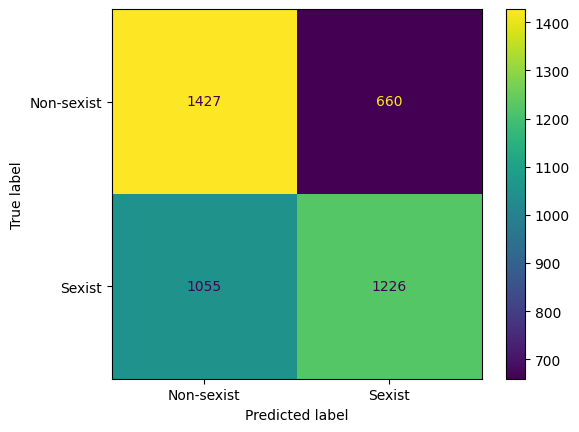

In [8]:
## LSTM VALIDATION
## Evaluate the trained LSTM model over train and test datasets
validate_lstm_model(
    model=lstm_model1,
    train_matrix=processed_data["train_matrix"],
    train_labels=processed_data["train_labels"],
    test_matrix=processed_data["test_matrix"],
    test_labels=processed_data["test_labels"]
)